# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from khan_helpers import Experiment
from khan_helpers.constants import FIG_DIR

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Load data, set constants

In [2]:
exp = Experiment()

cv = exp.fit_cv
lda = exp.fit_lda

In [3]:
N_TOPICS = lda.n_components
# (maximum) number of top-weighted words to show per topic
N_TOP_WORDS = 50

# Get top-weighted words in each discovered topic

In [4]:
vocabulary = cv.get_feature_names_out()
topics_matrix = lda.components_
topic_words_distribution = topics_matrix / topics_matrix.sum(axis=1)[:, None]

In [5]:
topic_rowlabels = (f'Topic {i}' for i in range(1, N_TOPICS+1))
df_index = pd.MultiIndex.from_product((topic_rowlabels, ['word', 'weight']))

word_weights_df = pd.DataFrame(index=df_index, columns=range(1, N_TOP_WORDS+1))

In [6]:
for topic_ix, word_weights in enumerate(topic_words_distribution): 
    top_ixs = word_weights.argsort()[::-1][:N_TOP_WORDS]
    top_weights = word_weights[top_ixs]
    top_words = vocabulary[top_ixs]
    word_weights_df.loc[f"Topic {topic_ix+1}", :len(top_ixs)] = np.stack(
        (top_words, top_weights)
    )

word_weights_df.head()

1         2                3         4         5   \
Topic 1 word        star    helium             main      mass    atomic   
        weight  0.059639  0.059471         0.057077  0.055335  0.045023   
Topic 2 word      charge     force             mass   gravity    strong   
        weight  0.054052  0.053484         0.034586  0.034442  0.030414   
Topic 3 word        huge     force  electromagnetic     macro       way   

                      6              7         8         9                10  \
Topic 1 word    sequence            get    energy      fuse         hydrogen   
        weight  0.042866       0.040228  0.040034  0.039944         0.039868   
Topic 2 word     attract          large  strength  distance  electromagnetic   
        weight  0.029436       0.027672  0.027554  0.022612         0.021084   
Topic 3 word       scale  concentration     apply      kind           charge   

                ...          41        42        43        44        45  \
Topic 1 word    ...       never       way      make  generate      heat   
        weight  ...    0.009274  0.007496  0.006728  0.005004  0.004102   
Topic 2 word    ...  especially    theory  equalize    become      else   
        weight  ...     0.00693   0.00693   0.00693   0.00693   0.00693   
Topic 3 word    ...      number  strength    wonder       put     place   

                      46        47        48        49        50  
Topic 1 word       point    object     small      huge    proton  
        weight  0.003143  0.003142  0.002853  0.002057  0.000432  
Topic 2 word        good  snowball   hundred  interact      type  
        weight   0.00693   0.00693   0.00693   0.00693   0.00693  
Topic 3 word    everyday  stronger  familiar      life      call  

[5 rows x 50 columns]

# Create figure

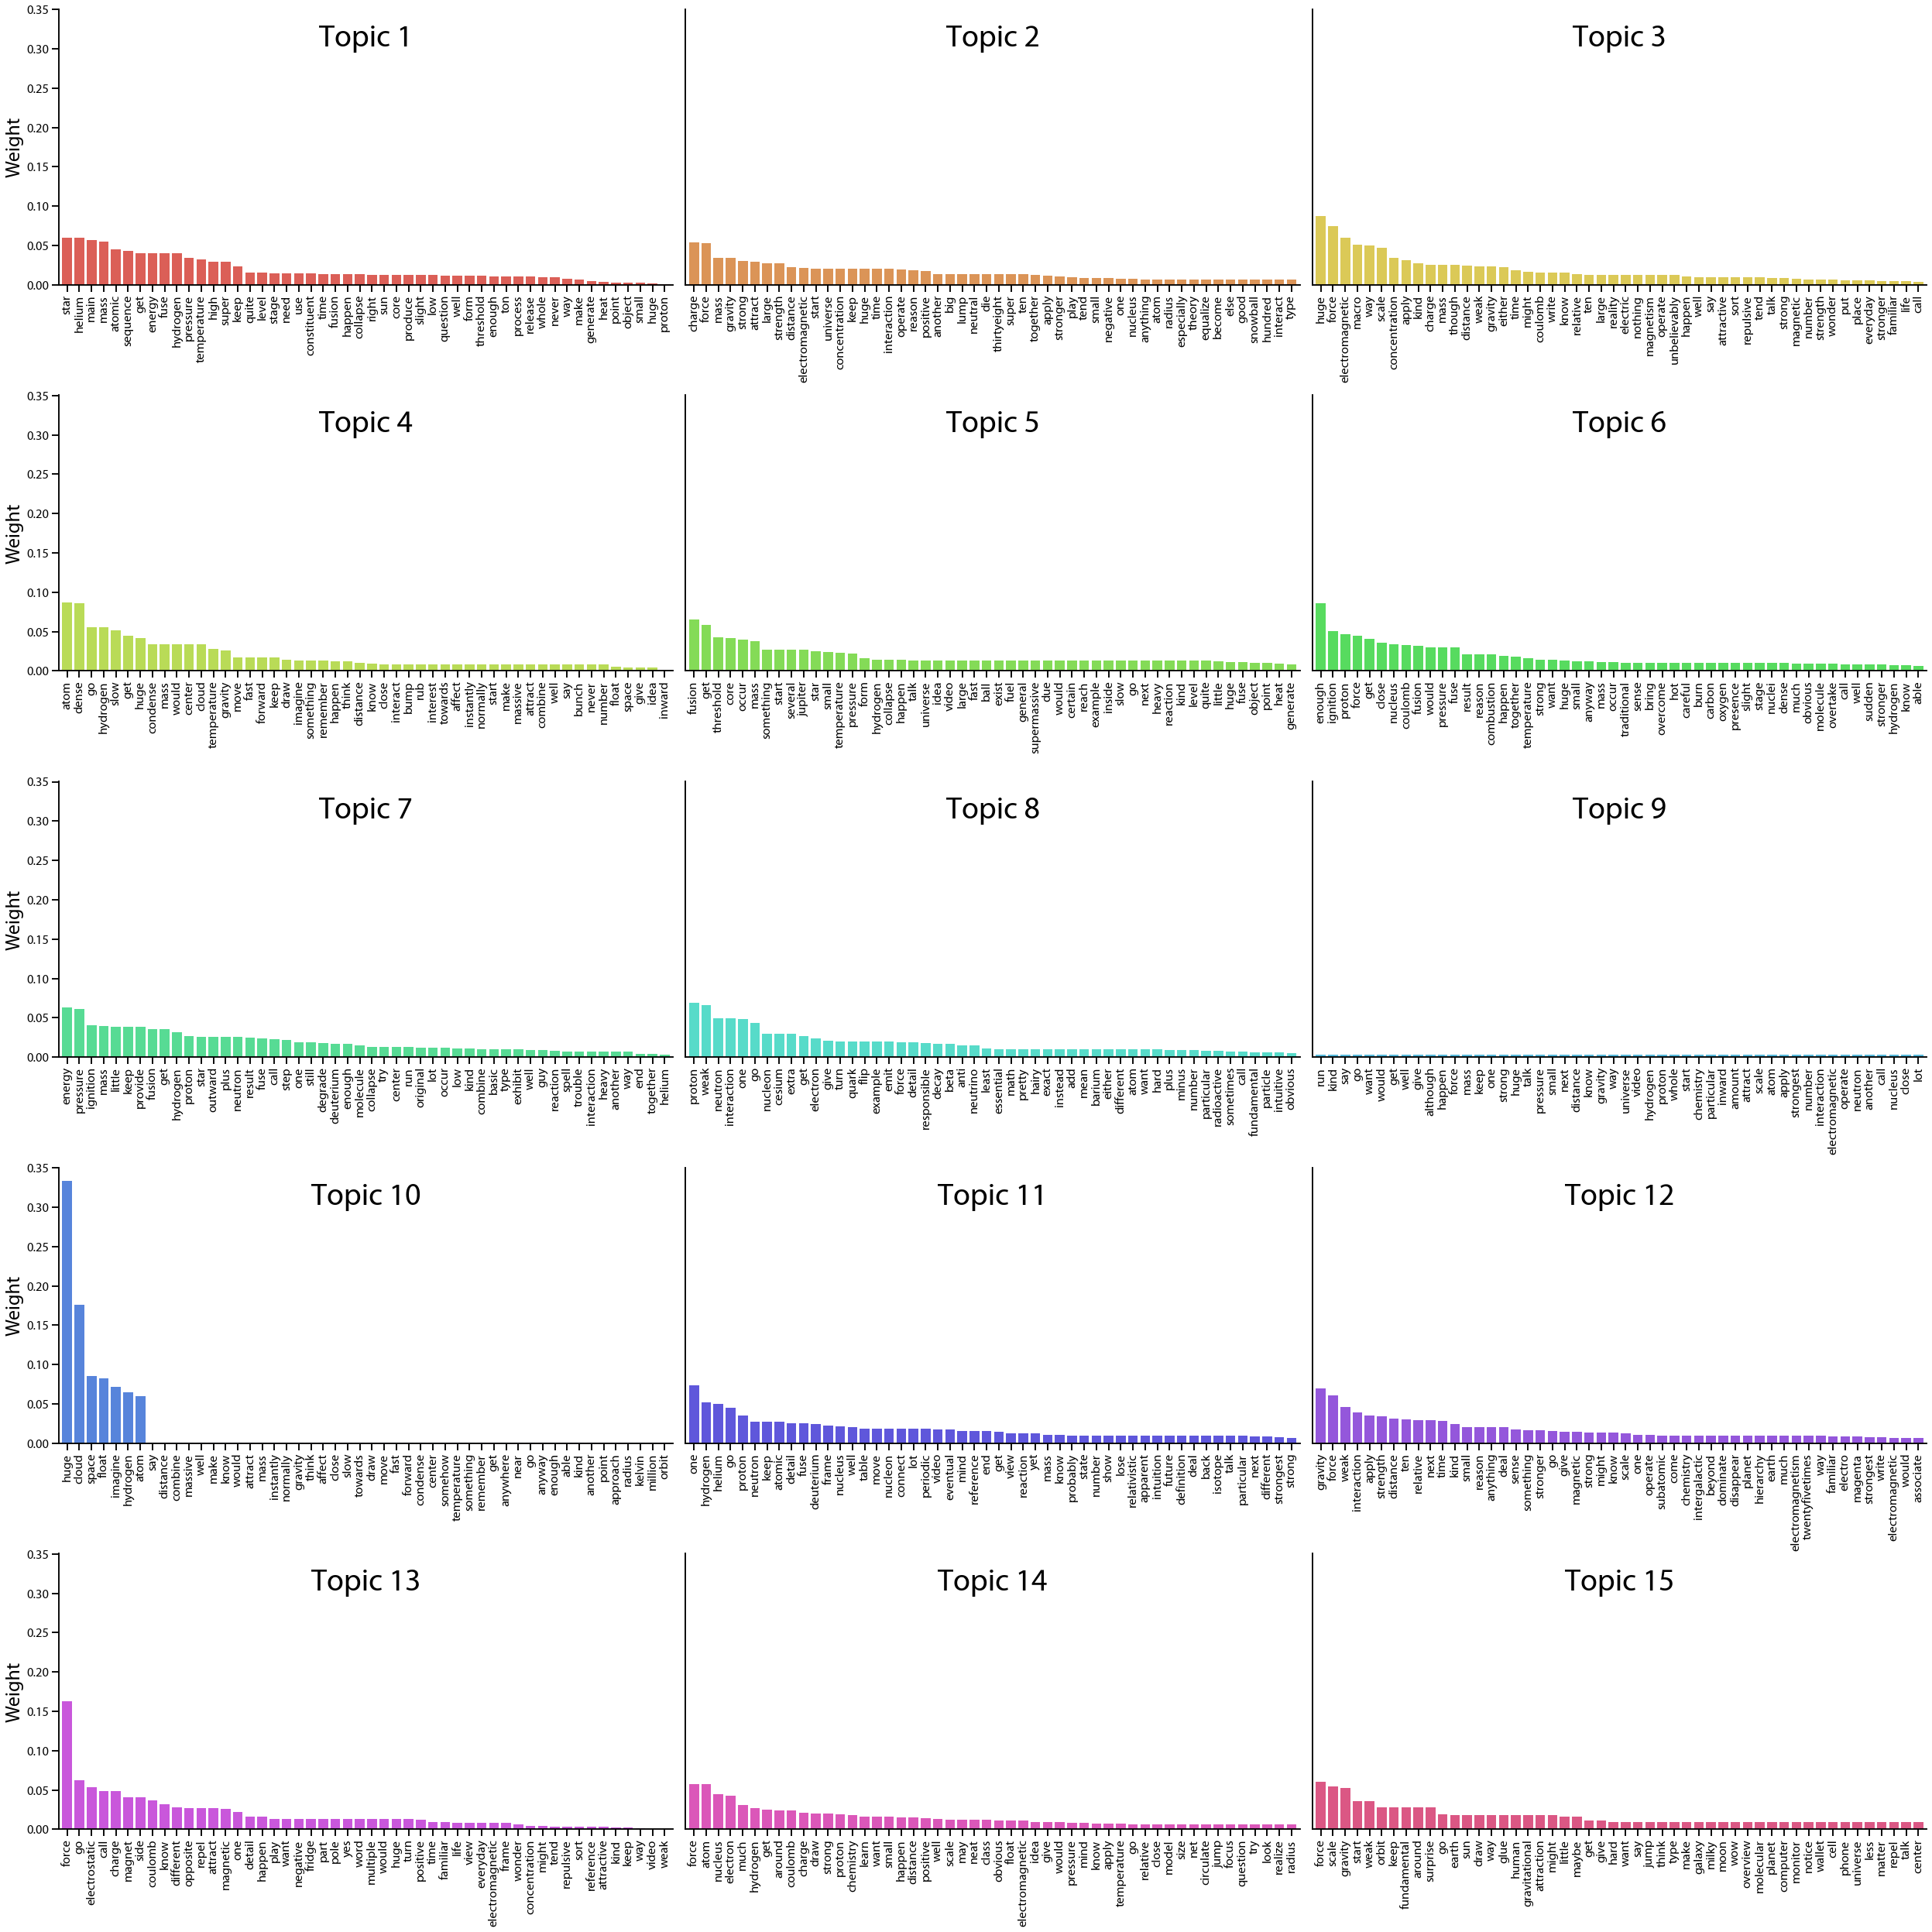

In [7]:
with sns.plotting_context('talk'):    
    fig, axarr = plt.subplots(5, 3, sharey=True, figsize=(35, 35))
    axarr = axarr.flatten()

    palette = sns.color_palette('hls', N_TOPICS)
    
    for topic_ix, ax in enumerate(axarr):
        topic_data = word_weights_df.loc[f"Topic {topic_ix+1}"].T.dropna()
        color = palette[topic_ix]
        ax.bar(range(len(topic_data)), topic_data['weight'], color=color)        
        ax.set_xticks(range(len(topic_data)), labels=topic_data['word'], rotation=90)
        ax.set_xlim(-0.7, N_TOP_WORDS - 0.3)
        ax.set_title(f"Topic {topic_ix + 1}", fontsize=40, y=0.85)
        
        ax.spines[['top', 'right']].set_visible(False)
        
        if topic_ix % 3:
            ax.tick_params(axis='y', length=0)
        else:
            ax.set_ylabel('Weight', fontsize='x-large')
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.4)
#     plt.savefig(FIG_DIR.joinpath('topic-word-distributions.pdf'), bbox_inches='tight')
    plt.show()